# Uploading files from kaggle

In [1]:
! pip install -q kaggle
from google.colab import files

In [2]:
# choose the kaggle.json file that you downloaded
files.upload()
! mkdir ~/.kaggle


Saving kaggle.json to kaggle.json


In [3]:
# make a directory named kaggle and copy the kaggle.json file there
!cp kaggle.json ~/.kaggle/



In [4]:
# change the permissions of the file
! chmod 600 ~/.kaggle/kaggle.json


In [5]:
! kaggle datasets download -d subhankarpanda56/news-bias

100% 110M/110M [00:05<00:00, 24.9MB/s]
100% 110M/110M [00:05<00:00, 20.0MB/s]


In [6]:
! unzip news-bias.zip

Archive:  news-bias.zip
  inflating: new_bias.csv            


# Installing and importing libraries

In [7]:
!pip install transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 98.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 105.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 12.1 MB/s eta 0:00:00


In [8]:
! pip install torch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

In [10]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# DATA PREPROCESSING

In [11]:
df = pd.read_csv("/content/new_bias.csv")
df.head(5)

,topic,source,bias,url,title,date,authors,content,content_original,source_url,bias_text,ID
0,terrorism,New York Times - News,0,http://www.nytimes.com/2016/09/20/nyregion/ahm...,"Bomb Suspect Changed After Trip Abroad, Friend...",2016-09-20,N. R. Kleinfield,"Besides his most recent trip to Quetta , Mr. R...","Besides his most recent trip to Quetta, Mr. Ra...",www.nytimes.com,left,004Gt3gcsotuiYmz
1,supreme_court,Vox,0,https://www.vox.com/policy-and-politics/2018/9...,Why Susan Collins claims she’s being bribed ov...,2018-09-12,"Emily Stewart, Terry Nguyen, Rebecca Jennings,...",Is Maine Republican Sen. Susan Collins being b...,Is Maine Republican Sen. Susan Collins being b...,www.vox.com,left,00eP4XD3VdMmHITE
2,education,Ezra Klein,0,http://www.npr.org/blogs/thetwo-way/2014/05/06...,Poll: Prestigious Colleges Won't Make You Happ...,2014-05-06,Anya Kamenetz,Poll : Prestigious Colleges Wo n't Make You Ha...,Poll: Prestigious Colleges Won't Make You Happ...,www.npr.org,left,00FTGIZEd6B8zQ4U
3,us_house,Breitbart News,2,http://www.breitbart.com/big-government/2017/0...,Paul Ryan Reportedly Says No Chance for Border...,2017-09-12,Ian Mason,"House Speaker Paul Ryan , at a private dinner ...","House Speaker Paul Ryan, at a private dinner e...",www.breitbart.com,right,00HGGqBRf1kzPRlg
4,white_house,Guest Writer - Left,0,https://www.cnn.com/2019/07/11/politics/donald...,OPINION: Trump seeking change of legal fortune...,2019-07-11,Analysis Stephen Collinson,( CNN ) President Donald Trump has reason to h...,(CNN) President Donald Trump has reason to hop...,www.cnn.com,left,00IzI5ynahBVtC9l


In [12]:
df.shape


(37554, 12)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37554 entries, 0 to 37553
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   topic             37554 non-null  object
 1   source            37554 non-null  object
 2   bias              37554 non-null  int64 
 3   url               37554 non-null  object
 4   title             37554 non-null  object
 5   date              33147 non-null  object
 6   authors           27886 non-null  object
 7   content           37554 non-null  object
 8   content_original  37554 non-null  object
 9   source_url        37554 non-null  object
 10  bias_text         37554 non-null  object
 11  ID                37554 non-null  object
dtypes: int64(1), object(11)
memory usage: 3.4+ MB


<Axes: >

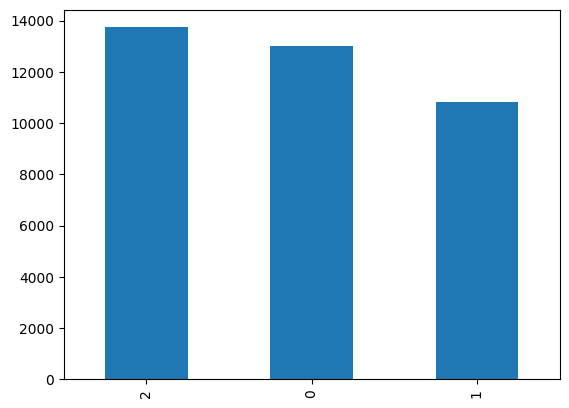

In [14]:
df['bias'].value_counts().plot(kind='bar')

In [15]:
class_names = ['left', 'neutral', 'right']

In [16]:
PRE_TRAINED_MODEL_NAME = 'bert-base-uncased'

In [17]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [18]:
MAX_LEN = 256

### Sliding window approach -  splitting the long articles into smaller sections and feed them to the model separately, as BERT has limitation of max sequence length of 512 tokens.

In [19]:
class GPReviewDataset(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len, stride):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
    self.stride = stride
    
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target = self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation= True,
      return_attention_mask=True,
      return_tensors='pt',
    )
    input_ids = encoding['input_ids'].flatten()
    attention_mask = encoding['attention_mask'].flatten()

    if len(input_ids) <= self.max_len:
      return {
        'review_text': review,
        'input_ids': input_ids,
        'attention_mask': attention_mask,
        'targets': torch.tensor(target, dtype=torch.long)
      }

    # Split the input into overlapping sections
    inputs = []
    masks = []
    for i in range(0, len(input_ids), self.stride):
      if i + self.max_len > len(input_ids):
        break
      inputs.append(input_ids[i:i+self.max_len])
      masks.append(attention_mask[i:i+self.max_len])
    targets = [target] * len(inputs)

    return {
      'review_text': review,
      'input_ids': torch.tensor(inputs, dtype=torch.long),
      'attention_mask': torch.tensor(masks, dtype=torch.long),
      'targets': torch.tensor(targets, dtype=torch.long)
    }


In [20]:
df_train, df_test = train_test_split(
  df,
  test_size=0.3,
  random_state=RANDOM_SEED
)
df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

In [21]:
df_train.shape, df_val.shape, df_test.shape

((26287, 12), (5633, 12), (5634, 12))

In [22]:
def create_data_loader(df, tokenizer, max_len, stride, batch_size):
  ds = GPReviewDataset(
    reviews=df.content.to_numpy(),
    targets=df.bias.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len,
    stride=stride
  )
  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )


In [23]:
BATCH_SIZE = 16
MAX_LEN = 256
STRIDE = 128

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, STRIDE, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, STRIDE, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, STRIDE, BATCH_SIZE)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [24]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [25]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 256])
torch.Size([16, 256])
torch.Size([16])


# LOADING MODELS

In [26]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
sample_txt = "This is a sample text"

In [28]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=256,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding=True,
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [29]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

In [30]:
bert_model.config.hidden_size

768

In [31]:
class SentimentClassifier(nn.Module):
  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.4)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  def forward(self, input_ids, attention_mask):
    _, pooled_output = self.bert(
      input_ids=input_ids,
      attention_mask=attention_mask,
      return_dict=False
      
    )
    output = self.drop(pooled_output)
    return self.out(output)

In [32]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [33]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 256])
torch.Size([16, 256])


In [34]:
import torch.nn.functional as F
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.4239, 0.2212, 0.3548],
        [0.4639, 0.2830, 0.2531],
        [0.2855, 0.4068, 0.3077],
        [0.4892, 0.2604, 0.2503],
        [0.3801, 0.2973, 0.3226],
        [0.3501, 0.3637, 0.2862],
        [0.3228, 0.3455, 0.3317],
        [0.3439, 0.2808, 0.3752],
        [0.3195, 0.3624, 0.3181],
        [0.4046, 0.3272, 0.2682],
        [0.3500, 0.2918, 0.3582],
        [0.5646, 0.2106, 0.2248],
        [0.3187, 0.3917, 0.2897],
        [0.2993, 0.3199, 0.3808],
        [0.3090, 0.3974, 0.2936],
        [0.4328, 0.1987, 0.3685]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Making a custom loss function that assigns different weights to class pairs based on their importance and calculates cross-entropy loss with weighted targets.

In [35]:
EPOCHS = 4
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False, weight_decay=0.01)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

import torch.nn.functional as F

class CustomLoss(nn.Module):
  def __init__(self, num_classes):
    super(CustomLoss, self).__init__()
    self.num_classes = num_classes
    self.weights = torch.ones((num_classes, num_classes))
    # Assign different weights to class pairs
    self.weights[0][1] = 2.0  # left vs centre
    self.weights[0][2] = 3.0  # left vs right
    self.weights[1][0] = 2.0  # centre vs left
    self.weights[1][2] = 2.5  # centre vs right
    self.weights[2][0] = 3.0  # right vs left
    self.weights[2][1] = 2.5  # right vs centre

  def forward(self, input, target):
    class_weights = torch.sum(self.weights, dim=1)
    return F.cross_entropy(input, target, weight=class_weights.to(device))


# Replace the previous loss function with the custom loss function
loss_fn = CustomLoss(num_classes=len(class_names)).to(device)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [36]:
def train_epoch(
  model,
  data_loader,
  loss_fn,
  optimizer,
  device,
  scheduler,
  n_examples
):
  model = model.train()
  losses = []
  correct_predictions = 0
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)
    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )
    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)
    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())
    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()
  return correct_predictions.double() / n_examples, np.mean(losses)

In [37]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()
  losses = []
  correct_predictions = 0
  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      loss = loss_fn(outputs, targets)
      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())
  return correct_predictions.double() / n_examples, np.mean(losses)

# TRAINING

In [38]:
%%time
history = defaultdict(list)
best_accuracy = 0
for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(df_train)
  )
  print(f'Train loss {train_loss} accuracy {train_acc}')
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(df_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)
  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.9975314498564418 accuracy 0.45334195609997335
Val   loss 0.7759687387234091 accuracy 0.6451269305876087

Epoch 2/4
----------
Train loss 0.6599535044017393 accuracy 0.7149161182333472
Val   loss 0.6183929868443492 accuracy 0.7464938753772412

Epoch 3/4
----------
Train loss 0.4912452682721238 accuracy 0.8067866245672766
Val   loss 0.5853857841427114 accuracy 0.771879992898988

Epoch 4/4
----------
Train loss 0.3813573826621363 accuracy 0.8581047666146764
Val   loss 0.6284690463108145 accuracy 0.771879992898988

CPU times: user 1h 4min 56s, sys: 33 s, total: 1h 5min 29s
Wall time: 1h 28min 19s


## SAVING THE MODEL

In [39]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [40]:
import pickle

In [41]:
pickle.dump(model,open("/content/drive/MyDrive/saved_models/model_BERT_2", 'wb'))

In [42]:
pickle.dump(model,open("/content/drive/MyDrive/saved_models/model_1_BERT_2.pkl", 'wb'))

## EVALUATION

In [43]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)
test_acc.item()

0.7802626908058218

In [44]:
def get_predictions(model, data_loader):
  model = model.eval()
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []
  with torch.no_grad():
    for d in data_loader:
      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)
      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)
      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(outputs)
      real_values.extend(targets)
  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [45]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
  model,
  test_data_loader
)

In [46]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

        left       0.78      0.77      0.78      1932
     neutral       0.79      0.78      0.79      1632
       right       0.77      0.78      0.78      2070

    accuracy                           0.78      5634
   macro avg       0.78      0.78      0.78      5634
weighted avg       0.78      0.78      0.78      5634



In [47]:
from sklearn.metrics import f1_score

review_texts, predictions, _, real_values = get_predictions(model, test_data_loader)
f1_macro = f1_score(real_values, predictions, average='macro')
print('Macro F1 score:', f1_macro)


/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Macro F1 score: 0.7807243299538547


In [48]:
def class_imbalance_metric(targets, predictions):
    """
    Calculates the class imbalance metric.

    Args:
        targets (numpy.ndarray): True class labels.
        predictions (numpy.ndarray): Predicted class labels.

    Returns:
        float: The class imbalance metric.
    """
    counts = np.bincount(targets)
    weights = counts.sum() / (len(counts) * counts)
    return (weights * (1 - (counts / len(targets)))).sum()

In [49]:
from sklearn.metrics import confusion_matrix

def class_imbalance_metric(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    total = cm.sum()
    correct = sum([cm[i][i] for i in range(len(cm))])
    return correct / total




In [50]:
# get model predictions
review_texts, preds, pred_probs, targets = get_predictions(model, test_data_loader)

# convert predictions and targets to numpy arrays
preds = preds.numpy()
targets = targets.numpy()

# calculate class imbalance metric
imbalance_metric = class_imbalance_metric(targets, preds)
print("Class Imbalance Metric: ", imbalance_metric)




/usr/local/lib/python3.9/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Class Imbalance Metric:  0.7802626908058218


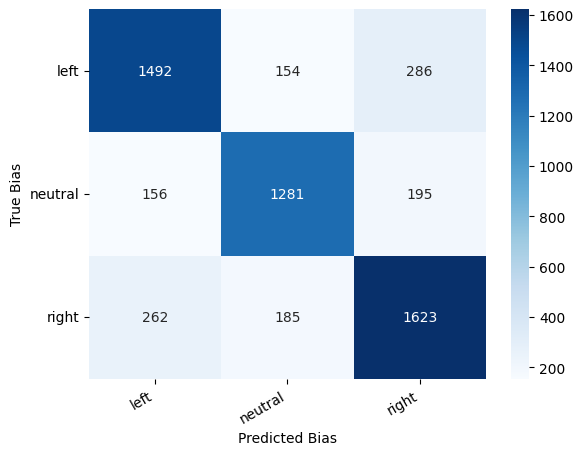

In [51]:
def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True Bias')
  plt.xlabel('Predicted Bias');
cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## INFERENCING

In [66]:
review_text = " Uncle Sam is a bit stingier this year when it comes to refunds on Americans’ income tax returns.The average refund check handed out to the 72 million Americans who filed their 2022 income tax returns as of March 17 was down 11%, according to figures calculated by the Internal Revenue Service.The IRS figures were first cited by Bloomberg News.According to the tax-collecting agency, the average refund payment was $2,993 — which is down 9.4% from $3,305 at the same time last year.As of March 17, the federal government has paid out $158 billion in income tax refunds — which is down from $171 billion a year ago.Experts told Bloomberg News that the change can be attributed to COVID-era government benefits being rolled back.In 2021, the Biden administration increased the child tax credit from $2,000 to $3,600 for children under the age of six as part of the American Rescue Plan.Americans who have filed their 2022 income tax returns have received less in refunds, according to Internal Revenue Service data.Americans who have filed their 2022 income tax returns have received less in refunds, according to Internal Revenue Service data.APBut the benefit was temporary and the administration’s attempts to extend it have failed to win support from Congress.The smaller refunds come at an inopportune time for tens of millions of Americans who are struggling to make ends meet due to stubbornly high levels of inflation.Prices increased 0.4% last month, just below January’s 0.5% rise.Yet excluding volatile food and energy costs, so-called core prices rose 0.5% in February, slightly above January’s 0.4% gain.When measured against prices a year ago, inflation has been easing for eight months. In February, consumer prices climbed 6% from 12 months earlier, down from January’s 6.4% year-over-year increase and well below a recent peak of 9.1% in June.As of March 17, the federal government has paid out $158 billion in income tax refunds -- which is down from $171 billion a year ago.As of March 17, the federal government has paid out $158 billion in income tax refunds — which is down from $171 billion a year ago.Christopher SadowskiYet it remains far above the Fed’s 2% annual inflation target. Core prices in February rose 5.5% from 12 months ago, down slightly from 5.6% in January."


In [67]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [79]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'News Article: {review_text}')
print(f'Bias  : {class_names[prediction]}')

News Article:  Uncle Sam is a bit stingier this year when it comes to refunds on Americans’ income tax returns.The average refund check handed out to the 72 million Americans who filed their 2022 income tax returns as of March 17 was down 11%, according to figures calculated by the Internal Revenue Service.The IRS figures were first cited by Bloomberg News.According to the tax-collecting agency, the average refund payment was $2,993 — which is down 9.4% from $3,305 at the same time last year.As of March 17, the federal government has paid out $158 billion in income tax refunds — which is down from $171 billion a year ago.Experts told Bloomberg News that the change can be attributed to COVID-era government benefits being rolled back.In 2021, the Biden administration increased the child tax credit from $2,000 to $3,600 for children under the age of six as part of the American Rescue Plan.Americans who have filed their 2022 income tax returns have received less in refunds, according to In

In [73]:
test2 = "If you’re feeling underwhelmed by the size of your income-tax refund this year, you’re probably not alone. Before the start of the 2023 filing season, tax professionals and the Internal Revenue Service were cautioning U.S. taxpayers that many refunds would likely be smaller this year due to the expiration of a number of pandemic-related boosts to tax credits and deductions.The filing deadline is Tuesday, April 18 — except for those who file for an extension — and the predictions about smaller refunds are coming into focus. The drop in refund amounts comes as particularly bad news at a time when historically high inflation is cooling only slowly.Also read: Yes, inflation does affect your tax return. Here are 5 things to watch out for.On Friday, the latest filing statistics from the IRS confirmed the trend on refund amounts. But while last-minute filers should be prepared to join the crowd of disappointed people, it’s not a hard and fast guarantee that they will.While many taxpayers are getting smaller refunds than they did last year, some wealthier taxpayers are seeing larger refunds this year, according to a new analysis from Bank of America. That might be explained by the capital losses investors can apply against their capital gains and income, researchers said. And investors sure did sustain losses last year, as stocks had their worst performance since 2008.For many people, an income-tax refund is a significant annual event in their financial lives. But like the tax code itself, lives are complicated. Here’s how refunds are playing out this tax season.Refunds are smallerWhen people filed their 2021 returns last year, millions of households got the second half of enhanced child tax-credit payouts in their refund. The credit for parents with childcare costs was as much as $8,000, instead of the previous $2,100 maximum for two or more dependents. The earned-income tax credit also applied to a larger swath of workers in 2021 and paid more to those without children. And even people who took the widely used standard deduction could deduct some charitable contributions.That all went away this year.The effects may already be showing up in the larger economy, with debit- and credit-card spending softening by 1.5% from February to March, according to Bank of America. Lower tax refunds are one part of the explanation for that, researchers said.Meanwhile, retail sales dropped 1% in March, according to Friday’s data. It was the biggest drop in four months.Many will use their refund to pay off debtThere was a clear divide between the incomes of taxpayers who filed before April 1 last year and those who filed after that date, according to research from TurboTax.The data is from 2022, but it’s likely that the trend continued this year, said Lisa Greene-Lewis, a certified public accountant and tax expert at TurboTax.And even if the average refund is lower than it was last year, it’s still a large sum of money that means a lot to people who may have little in the way of savings. “The refund, for a lot of people, it’s the biggest paycheck that they get all year and they rely on it for bills or to get ahead,” Greene-Lewis said.Nearly one-third of people (28%) said they would use their refund money to pay down debts, while 26% said they would put the money in savings, according to a Bankrate survey last month.Opinion: We all know an emergency fund is important. Here’s how to get started.Not all refunds are lowerIn an analysis released Thursday, Bank of America reviewed internal data to see if lower refunds were consistent across income groups. They weren’t.The largest drops came for households with income under $50,000. Households earning between $50,000 and $125,000 also saw lower refunds year over year. But it was a different story for households earning more than $125,000.What explains the refund disparity that is giving a boost to wealthier taxpayers? The researchers have one theory. “In our view, this could be due to realized losses in capital markets for higher-income households,” they wrote.Investors can sell capital assets, like stocks, at a loss and apply those losses to offset capital gains. If losses exceed gains, losses up to $3,000 can be deducted and the remainder can get carried forward. (The $3,000 capital-loss limitation has been in place since 1978.)Tax-loss harvesting is a strategy to gather up multiple capital losses, and last year’s market conditions likely made it a tempting strategy. Stocks and bonds were socked by recession worries, rising interest rates and the heavy toll of inflation.Also read: U.S. billionaires have grown nearly one-third richer during the pandemic, while a ‘permanent underclass’ struggles, Oxfam saysAnother theory about why higher-income households are seeing higher refunds this year has to do with estimated tax payments, according to Jason Stein, founder of Bluepoint Wealth in Orange County, Calif.Stein doesn’t prepare tax returns, but he does help clients with their tax planning and strategies. While salaried wage earners have taxes taken out of every paycheck, people who rely on investment income pay their taxes for the coming year quarterly, Stein noted.Equities had a high-flying performance in 2021. If investors based their 2022 estimated tax payments on what they owed for 2021, Stein said, they might have been overpaying.“If your income is largely attributed to investment earnings, your investment earnings can vary substantially between those two years,” he said.On Friday, the Dow Jones Industrial Average DJIA, -0.42%, S&P 500 SPX, -0.21% and Nasdaq Composite COMP, -0.35% all closed lower despite big first-quarter earnings beats from the country’s largest banks.Year to date, the Dow is up more than 2%, while the S&P is up 7.7% and the Nasdaq is up 15.8%"


In [74]:
encoded_review2 = tokenizer.encode_plus(
  test2,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  padding="max_length",
  truncation=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [84]:
input_ids = encoded_review2['input_ids'].to(device)
attention_mask = encoded_review2['attention_mask'].to(device)
output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)
print(f'News Article: {test2}')
print(f'Bias  : {class_names[prediction]}')

News Article: If you’re feeling underwhelmed by the size of your income-tax refund this year, you’re probably not alone. Before the start of the 2023 filing season, tax professionals and the Internal Revenue Service were cautioning U.S. taxpayers that many refunds would likely be smaller this year due to the expiration of a number of pandemic-related boosts to tax credits and deductions.The filing deadline is Tuesday, April 18 — except for those who file for an extension — and the predictions about smaller refunds are coming into focus. The drop in refund amounts comes as particularly bad news at a time when historically high inflation is cooling only slowly.Also read: Yes, inflation does affect your tax return. Here are 5 things to watch out for.On Friday, the latest filing statistics from the IRS confirmed the trend on refund amounts. But while last-minute filers should be prepared to join the crowd of disappointed people, it’s not a hard and fast guarantee that they will.While many 